# <center> Variance Reduced GD: Non-Convex</center>
### <center> Vishnu Vinod \& Sathvik Joel K </center>

## Import Libraries

In [1]:
import sys
import time
import copy
import tqdm
import pickle
import random
import numpy as np
import seaborn as sns
from tqdm import tqdm
from datetime import datetime 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Optimizer
from torch.nn import ReLU, Conv2d, Linear
from torch.nn import Softmax, LogSoftmax
from torch.nn import MaxPool2d, BatchNorm2d
from torch.autograd import Variable, grad

import torchvision
from torchsummary import summary
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'
print(device)

cuda


## Dataset Preparation

In [4]:
max_iter = 100
batch_size = 50

In [5]:
transform1 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
transform2 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = {}
dataset['Ctrain'] = CIFAR10(root='./data', train=True, download=True, transform=transform2)
dataset['Ctest'] = CIFAR10(root='./data', train=False, download=True, transform=transform2)
dataset['Mtrain'] = MNIST('./mnist/', train = True, download = True, transform = transform1)
dataset['Mtest'] = MNIST('./mnist/', train = False, download = True, transform = transform1)

dataloader = {}
dataloader['Mtrain'] = torch.utils.data.DataLoader(dataset['Mtrain'], batch_size=batch_size, shuffle = False, drop_last = True)
dataloader['Mtest'] = torch.utils.data.DataLoader(dataset['Mtest'], batch_size=batch_size, shuffle = False, drop_last = True)
dataloader['Ctrain'] = torch.utils.data.DataLoader(dataset['Ctrain'], batch_size=batch_size, shuffle = False, drop_last = True)
dataloader['Ctest'] = torch.utils.data.DataLoader(dataset['Ctest'], batch_size=batch_size, shuffle = False, drop_last = True)

Files already downloaded and verified
Files already downloaded and verified


## Helper Functions

In [6]:
def accuracy(yhat, labels):
    _, indices = yhat.max(1)
    return (indices == labels).sum().data.item(), float(len(labels))

In [7]:
def plot_train_stats(train_loss, train_acc, method = 'sgd', model = '1hidden', dataset = 'mnist', save = False):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
    axes[0].plot(np.array(train_loss))
    axes[0].set_title("Train loss")
    axes[1].plot(np.array(train_acc))
    axes[1].set_title("Train Accuracy")
    axes[1].set_ylim(0, 1)
    plt.tight_layout()
    exp_name = method + '_' + model + '_' + dataset
    if save: plt.savefig('.\plots\train_stats_' + exp_name + '.png')
    plt.show()
    plt.close()

## Models

In [8]:
class Model1(nn.Module):
    """Single hidden layer MLP"""

    def __init__(self, in_channels = 1, num_classes = 10, image_size = 28):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.image_size = image_size

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels*image_size**2, 500),
            nn.ReLU(),
            
            nn.Linear(500, self.num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        out = self.model(x)
        return out

In [9]:
class Model2(nn.Module):
    """Double Hidden Layer MLP"""

    def __init__(self, in_channels = 1, num_classes = 10, image_size = 28):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.image_size = image_size

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels*image_size**2, 500),
            nn.ReLU(),
            
            nn.Linear(500, 100),
            nn.ReLU(),
            
            nn.Linear(100, self.num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        out = self.model(x)
        return out

In [10]:
class Model3(nn.Module):
    """Triple Hidden Layer MLP"""

    def __init__(self, in_channels = 1, num_classes = 10, image_size = 28):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.image_size = image_size

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels*image_size**2, 500),
            nn.ReLU(),
            
            nn.Linear(500, 200),
            nn.ReLU(),
            
            nn.Linear(200, 50),
            nn.ReLU(),
            
            nn.Linear(50, self.num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        out = self.model(x)
        return out

In [11]:
models = {'1hidden': Model1, '2hidden': Model2, '3hidden': Model3}

In [12]:
# sanity check

# MNIST
summary(Model1().to(device), (1,28,28))
summary(Model2().to(device), (1,28,28))
summary(Model3().to(device), (1,28,28))

# CIFAR
summary(Model1(in_channels = 3, image_size = 32).to(device), (3,32,32))
summary(Model2(in_channels = 3, image_size = 32).to(device), (3,32,32))
summary(Model3(in_channels = 3, image_size = 32).to(device), (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
            Linear-4                   [-1, 10]           5,010
        LogSoftmax-5                   [-1, 10]               0
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.52
Estimated Total Size (MB): 1.53
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1

## SVRG Optimizers

In [13]:
class SVRG_k(Optimizer):
    # Optimization class for calculating the gradient of one iteration.
    def __init__(self, params, lr, weight_decay=0):
#         print("Using optimizer: SVRG")
        self.u = None
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(SVRG_k, self).__init__(params, defaults)
    
    def get_param_groups(self):
            return self.param_groups

    def set_u(self, new_u):
        """Set the mean gradient for the current epoch. 
        """
        if self.u is None:
            self.u = copy.deepcopy(new_u)
        for u_group, new_group in zip(self.u, new_u):  
            for u, new_u in zip(u_group['params'], new_group['params']):
                u.grad = new_u.grad.clone()

    def step(self, params):
        for group, new_group, u_group in zip(self.param_groups, params, self.u):
            weight_decay = group['weight_decay']

            for p, q, u in zip(group['params'], new_group['params'], u_group['params']):
                if p.grad is None:
                    continue
                if q.grad is None:
                    continue
                # core SVRG gradient update 
                new_d = p.grad.data - q.grad.data + u.grad.data
                if weight_decay != 0:
                    new_d.add_(weight_decay, p.data)
                p.data.add_(-group['lr'], new_d)

In [14]:
class SVRG_Snapshot(Optimizer):
    #Optimization class for calculating the mean gradient (snapshot) of all samples.
    def __init__(self, params):
        defaults = dict()
        super(SVRG_Snapshot, self).__init__(params, defaults)
      
    def get_param_groups(self):
            return self.param_groups
    
    def set_param_groups(self, new_params):
        for group, new_group in zip(self.param_groups, new_params): 
            for p, q in zip(group['params'], new_group['params']):
                  p.data[:] = q.data[:]

## SVRG

In [15]:
def train_epoch_SVRG(model_k, model_snapshot, optimizer_k, optimizer_snapshot, trainloader, loss_fn):
    model_k.train()
    model_snapshot.train()
    loss = 0
    acc = 0
    tot = 0

    # calculate the mean gradient
    optimizer_snapshot.zero_grad()  # zero_grad outside for loop, accumulate gradient inside
    for images, labels in trainloader:
        images = images.to(device)
        yhat = model_snapshot(images)
        labels = labels.to(device)
        snapshot_loss = loss_fn(yhat, labels) / len(trainloader)
        snapshot_loss.backward()

    # pass the current paramesters of optimizer_0 to optimizer_k 
    u = optimizer_snapshot.get_param_groups()
    optimizer_k.set_u(u)
    
    for images, labels in trainloader:
        images = images.to(device)
        yhat = model_k(images)
        labels = labels.to(device)
        loss_iter = loss_fn(yhat, labels)

        # optimization 
        optimizer_k.zero_grad()
        loss_iter.backward()    

        yhat2 = model_snapshot(images)
        loss2 = loss_fn(yhat2, labels)

        optimizer_snapshot.zero_grad()
        loss2.backward()

        optimizer_k.step(optimizer_snapshot.get_param_groups())

        # logging 
        loss += loss_iter.data.item()
        x,y = accuracy(yhat, labels)
        acc, tot = acc + x, tot + y
    
    # update the snapshot 
    optimizer_snapshot.set_param_groups(optimizer_k.get_param_groups())
    avg_acc = acc/tot
    avg_loss = loss/tot
    
    return avg_loss, avg_acc

In [16]:
def train_SVRG(model_name = '1hidden', dataset = 'mnist', l2 = '0', scheduler = None,  lr = 0.001, n_epochs = max_iter):
    
    trainloader = None
    lamb = 0
    if l2 != '0': lamb = 10**(-int(l2))
    print('Lambda:', lamb)
        
    if dataset == 'mnist':
        trainloader = dataloader['Mtrain'] 
        in_channels = 1
        image_size = 28
    elif dataset == 'cifar':
        trainloader = dataloader['Ctrain'] 
        in_channels = 3
        image_size = 32
        
        
    train_loss, train_acc = [], []
    model = models[model_name](in_channels = in_channels, image_size = image_size).to(device)
    model_snapshot = models[model_name](in_channels = in_channels, image_size = image_size).to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SVRG_k(model.parameters(), lr=lr, weight_decay=lamb)
    optimizer_snapshot = SVRG_Snapshot(model_snapshot.parameters())
    
    for epoch in range(n_epochs):
        loss, acc = train_epoch_SVRG(model, model_snapshot, optimizer, optimizer_snapshot, trainloader, loss_fn)
        
        train_loss.append(loss)
        train_acc.append(acc)
        if (epoch+1)%10 == 0: print('Iter',epoch+1, ':  Loss:',np.mean(loss), 'Acc:',acc)
#     plot_train_stats(train_loss, train_acc, 'svrg', model_name, dataset)
    name = 'svrg_' + model_name + '_' + dataset + '_reg' + l2
    return name, train_loss, train_acc

## Experiments: SVRG

In [17]:
# results_svrg = {}

In [18]:
with open('./logs/results_svrg.txt', 'rb') as f:
    results_svrg = pickle.load(f)

# with open('./logs/svrg.log', 'w') as f:
# sys.stdout = f 
regs = ['0', '2', '4', '6']
counter = 1
for l2 in regs:
    for dataset in ['mnist','cifar']:
        lr = 0.001 if dataset == 'mnist' else 0.01
        for model in ['1hidden', '2hidden', '3hidden']:
            print('Experiment', counter)
            print('Dataset:', dataset)
            print('Model:', model)
            print('LR:', lr)

            counter += 1
            tick = datetime.now()
            name, loss, acc = train_SVRG(model_name = model, dataset = dataset, lr = lr, l2 = l2)
            results_svrg[name] = (loss, acc)
            tock = datetime.now()
            with open('./logs/results_svrg.txt', 'wb') as f1:
                pickle.dump(results_svrg,f1) 

            print()
            print('Time Taken:', tock - tick)
            print()
            print('*********************************************************************')

Experiment 1
Dataset: mnist
Model: 1hidden
LR: 0.001
Lambda: 0


/tmp/ipykernel_214/3873502961.py:34: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  p.data.add_(-group['lr'], new_d)


Iter 10 :  Loss: 0.0060083788382510345 Acc: 0.9148166666666666
Iter 20 :  Loss: 0.004712453777870784 Acc: 0.9335833333333333
Iter 30 :  Loss: 0.003911221968134244 Acc: 0.9457
Iter 40 :  Loss: 0.003342932228790596 Acc: 0.9534833333333333
Iter 50 :  Loss: 0.0029199808083940296 Acc: 0.95915
Iter 60 :  Loss: 0.0025920175655977803 Acc: 0.96405
Iter 70 :  Loss: 0.0023283796324472254 Acc: 0.9683
Iter 80 :  Loss: 0.0021109867928937698 Acc: 0.9715166666666667
Iter 90 :  Loss: 0.0019279942294078258 Acc: 0.9740166666666666
Iter 100 :  Loss: 0.0017720919516907695 Acc: 0.976

Time Taken: 0:35:38.867281

*********************************************************************
Experiment 2
Dataset: mnist
Model: 2hidden
LR: 0.001
Lambda: 0
Iter 10 :  Loss: 0.006271922144293785 Acc: 0.90955
Iter 20 :  Loss: 0.004700805819313973 Acc: 0.9328333333333333
Iter 30 :  Loss: 0.003763979521533474 Acc: 0.94685
Iter 40 :  Loss: 0.00311082549309358 Acc: 0.9560666666666666
Iter 50 :  Loss: 0.0026296527322769788 Acc: 

Iter 100 :  Loss: 0.016199287436008455 Acc: 0.7316

Time Taken: 0:33:08.277292

*********************************************************************
Experiment 13
Dataset: mnist
Model: 1hidden
LR: 0.001
Lambda: 0.0001
Iter 10 :  Loss: 0.005963297491831084 Acc: 0.91555
Iter 20 :  Loss: 0.004661525012335429 Acc: 0.9345
Iter 30 :  Loss: 0.003879684136932095 Acc: 0.9459666666666666
Iter 40 :  Loss: 0.0033224406338917714 Acc: 0.9538333333333333
Iter 50 :  Loss: 0.0029024835640719783 Acc: 0.9601333333333333
Iter 60 :  Loss: 0.0025750148729421197 Acc: 0.9647166666666667
Iter 70 :  Loss: 0.0023116221287675823 Acc: 0.96895
Iter 80 :  Loss: 0.0020948420701160405 Acc: 0.97245
Iter 90 :  Loss: 0.0019133923860732466 Acc: 0.9747166666666667
Iter 100 :  Loss: 0.0017587181606174757 Acc: 0.9765

Time Taken: 0:34:44.066279

*********************************************************************
Experiment 14
Dataset: mnist
Model: 2hidden
LR: 0.001
Lambda: 0.0001
Iter 10 :  Loss: 0.006290007570323845 Acc:

Iter 20 :  Loss: 0.015055570870041847 Acc: 0.73834
Iter 30 :  Loss: 0.010444388829171657 Acc: 0.8179
Iter 40 :  Loss: 0.007703730829656124 Acc: 0.86726
Iter 50 :  Loss: 0.006242537970170378 Acc: 0.89136
Iter 60 :  Loss: 0.005101345077604055 Acc: 0.90934
Iter 70 :  Loss: 0.004260660928040743 Acc: 0.92538
Iter 80 :  Loss: 0.0032103989673033357 Acc: 0.9437
Iter 90 :  Loss: 0.003030722551587969 Acc: 0.9471
Iter 100 :  Loss: 0.0025309643936529754 Acc: 0.9555

Time Taken: 0:32:01.010771

*********************************************************************


In [26]:
with open('./logs/results_svrg.txt', 'rb') as f:
    results_svrg = pickle.load(f)
results_svrg.keys()

dict_keys(['svrg_1hidden_mnist_reg0', 'svrg_2hidden_mnist_reg0', 'svrg_3hidden_mnist_reg0', 'svrg_1hidden_cifar_reg0', 'svrg_2hidden_cifar_reg0', 'svrg_3hidden_cifar_reg0', 'svrg_1hidden_mnist_reg2', 'svrg_2hidden_mnist_reg2', 'svrg_3hidden_mnist_reg2', 'svrg_1hidden_cifar_reg2', 'svrg_2hidden_cifar_reg2', 'svrg_3hidden_cifar_reg2', 'svrg_1hidden_mnist_reg4', 'svrg_2hidden_mnist_reg4', 'svrg_3hidden_mnist_reg4', 'svrg_1hidden_cifar_reg4', 'svrg_2hidden_cifar_reg4', 'svrg_3hidden_cifar_reg4', 'svrg_1hidden_mnist_reg6', 'svrg_2hidden_mnist_reg6', 'svrg_3hidden_mnist_reg6', 'svrg_1hidden_cifar_reg6', 'svrg_2hidden_cifar_reg6', 'svrg_3hidden_cifar_reg6'])

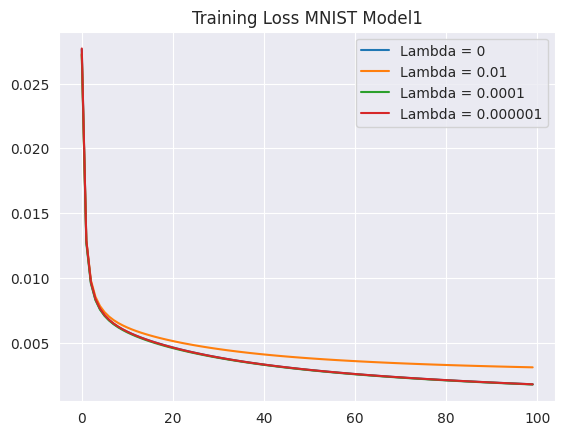

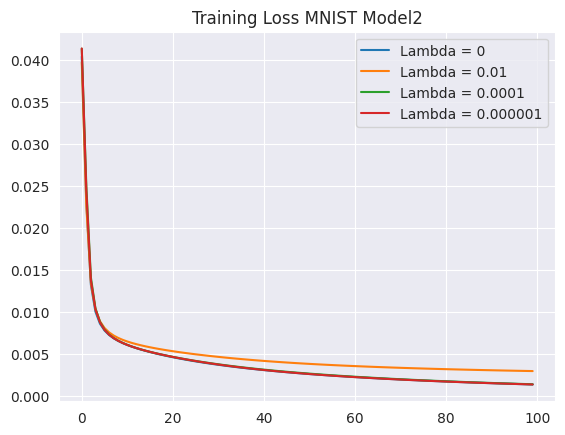

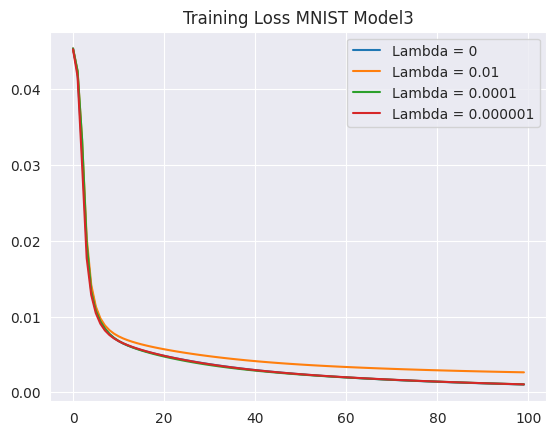

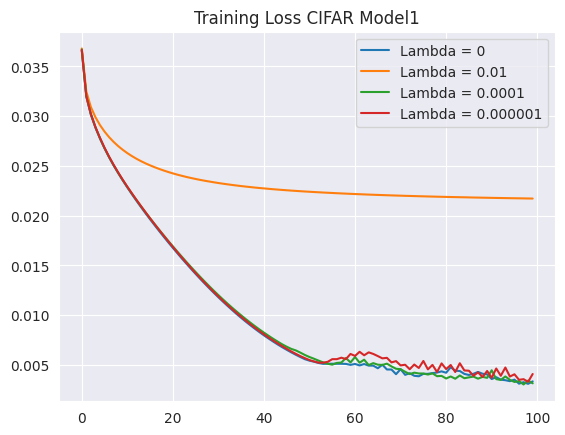

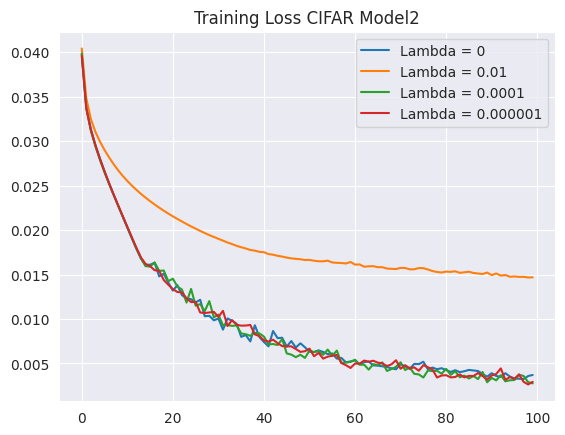

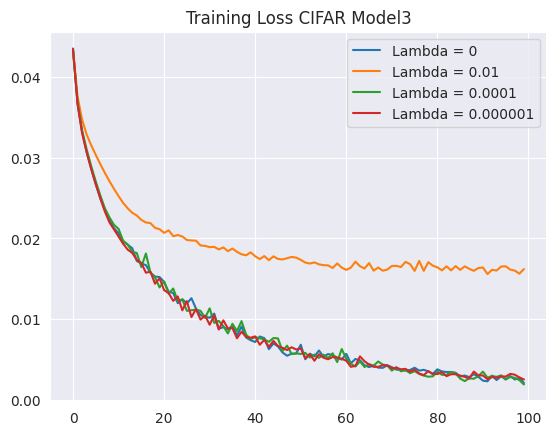

In [27]:
for dataset in ['mnist','cifar']:
    for i,model_name in enumerate(['1hidden', '2hidden', '3hidden']):
        sns.set_style("darkgrid")
        fig = plt.figure()
        for l2 in ['0', '2', '4', '6']:
            name = 'svrg_' + model_name + '_' + dataset + '_reg' + l2
            plt.plot(range(100), results_svrg[name][0])
            
        plt.legend(loc = 'upper right', labels = ['Lambda = 0', 'Lambda = 0.01', 'Lambda = 0.0001', 'Lambda = 0.000001'])
        plt.title('Training Loss '+str(dataset).upper() +' Model'+str(i+1))
        plt.show()

# Training Loop for SGD, SAG and Adam

In [41]:
def train_epoch(model, optimizer, trainloader, loss_fn):
    model.train()
    loss = 0
    acc = 0
    tot = 0
    
    for images, labels in trainloader:
        images = images.to(device)
        yhat = model(images)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        loss_iter = loss_fn(yhat, labels)

        # optimization 
        loss_iter.backward()
        optimizer.step()

        # logging 
        loss += loss_iter.data.item()
        x,y = accuracy(yhat, labels)
        acc, tot = acc + x, tot + y

    avg_acc = acc/tot
    avg_loss = loss/tot
    
    return avg_loss, avg_acc

In [42]:
def train(model_name = '1hidden', dataset = 'mnist', l2 = '0', opt = 'SGD', lr_decay = 1.0, lr = 0.007, n_epochs = max_iter, lr_print = False):
    trainloader = None
    lamb = 0
    if l2 != '0': lamb = 10**(-int(l2))
    print('Lambda:', lamb)
        
    if dataset == 'mnist':
        trainloader = dataloader['Mtrain'] 
        in_channels = 1
        image_size = 28
    elif dataset == 'cifar':
        trainloader = dataloader['Ctrain'] 
        in_channels = 3
        image_size = 32
        
        
    train_loss, train_acc = [], []
    model = models[model_name](in_channels = in_channels, image_size = image_size).to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = None
    
    if opt == 'SGD': optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = lamb)
    elif opt == 'Adam': optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = lamb)
    elif opt == 'SAG': optimizer = optim.ASGD(model.parameters(), lr = lr, weight_decay = lamb)
        
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = lr_decay, verbose = False)
    
    for epoch in range(n_epochs):
        loss, acc = train_epoch(model, optimizer, trainloader, loss_fn)
        train_loss.append(loss)
        train_acc.append(acc)
        
        if lr_print and (epoch+1)%10 == 0: print('Iter',epoch+1, ':  Loss:',np.mean(loss), 'Acc:',acc, 'LR:', lr)
        elif (epoch+1)%10 == 0: print('Iter',epoch+1, ':  Loss:',np.mean(loss), 'Acc:',acc)
            
        scheduler.step()
            
    name = 'sgd1_' + model_name + '_' + dataset + '_reg' + l2
    return name, train_loss, train_acc

## Experiments: SGD (with constant step size)

We now experiment using a tuned Stochastic Gradient Descent (SGD) with a constant step size.

In [23]:
results_sgd1 = {}

In [24]:
# with open('./logs/results_sgd1.txt', 'rb') as f:
#     results_sgd1 = pickle.load(f)

# with open('./logs/sgd1.log', 'w') as f:
# sys.stdout = f 
regs = ['0', '2', '4', '6']
counter = 1
for l2 in regs:
    for dataset in ['mnist','cifar']:
        lr = 0.001 if dataset == 'mnist' else 0.01
        for model in ['1hidden', '2hidden', '3hidden']:
            print('Experiment', counter)
            print('Dataset:', dataset)
            print('Model:', model)
            print('LR:', 0.001 if dataset == 'mnist' else 0.01)

            counter += 1
            tick = datetime.now()
            name, loss, acc = train(model_name = model, dataset = dataset, lr = lr, l2 = l2)
            results_sgd1[name] = (loss, acc)
            tock = datetime.now()
            with open('./logs/results_sgd1.txt', 'wb') as f1:
                pickle.dump(results_sgd1, f1) 

            print('Time Taken:', tock - tick)
            print()
            print()
            print('*********************************************************************')

Experiment 1
Dataset: mnist
Model: 1hidden
LR: 0.001
Lambda: 0
Iter 10 :  Loss: 0.0060270967133964105 Acc: 0.91425
Iter 20 :  Loss: 0.004727859666539977 Acc: 0.9331333333333334
Iter 30 :  Loss: 0.003923915815462048 Acc: 0.9454
Iter 40 :  Loss: 0.0033542182554646086 Acc: 0.9535666666666667
Iter 50 :  Loss: 0.0029304466968402268 Acc: 0.9589166666666666
Iter 60 :  Loss: 0.0026019055308618894 Acc: 0.9637333333333333
Iter 70 :  Loss: 0.0023377015381973857 Acc: 0.9679833333333333
Iter 80 :  Loss: 0.0021199912703285615 Acc: 0.9712833333333334
Iter 90 :  Loss: 0.0019366927224289004 Acc: 0.9737833333333333
Iter 100 :  Loss: 0.0017804717200497785 Acc: 0.9758666666666667
Time Taken: 0:18:09.524445


*********************************************************************
Experiment 2
Dataset: mnist
Model: 2hidden
LR: 0.001
Lambda: 0
Iter 10 :  Loss: 0.006303371766892572 Acc: 0.9101666666666667
Iter 20 :  Loss: 0.004703633834266414 Acc: 0.93295
Iter 30 :  Loss: 0.003771136591412748 Acc: 0.94643333333

Iter 40 :  Loss: 0.021023838336467742 Acc: 0.63456
Iter 50 :  Loss: 0.020006094893217086 Acc: 0.65428
Iter 60 :  Loss: 0.01923514198899269 Acc: 0.66954
Iter 70 :  Loss: 0.018631715041399002 Acc: 0.68104
Iter 80 :  Loss: 0.018138692767620087 Acc: 0.6918
Iter 90 :  Loss: 0.017719494013786315 Acc: 0.70224
Iter 100 :  Loss: 0.017352046085596085 Acc: 0.70896
Time Taken: 0:16:14.125582


*********************************************************************
Experiment 13
Dataset: mnist
Model: 1hidden
LR: 0.001
Lambda: 0.0001
Iter 10 :  Loss: 0.006055914953785638 Acc: 0.9140666666666667
Iter 20 :  Loss: 0.004742369269517561 Acc: 0.9329833333333334
Iter 30 :  Loss: 0.003927365541830659 Acc: 0.9445333333333333
Iter 40 :  Loss: 0.003351546727369229 Acc: 0.9534
Iter 50 :  Loss: 0.0029251627180725335 Acc: 0.9597333333333333
Iter 60 :  Loss: 0.002595886992771799 Acc: 0.96455
Iter 70 :  Loss: 0.0023326432410938043 Acc: 0.9683
Iter 80 :  Loss: 0.002116360956686549 Acc: 0.9716666666666667
Iter 90 :  Lo

Iter 90 :  Loss: 0.000550158030805178 Acc: 0.99452
Iter 100 :  Loss: 0.00012023106826469302 Acc: 0.99998
Time Taken: 0:14:45.412912


*********************************************************************
Experiment 24
Dataset: cifar
Model: 3hidden
LR: 0.01
Lambda: 1e-06
Iter 10 :  Loss: 0.024472016019821168 Acc: 0.56922
Iter 20 :  Loss: 0.01659527246952057 Acc: 0.71288
Iter 30 :  Loss: 0.010143590379357338 Acc: 0.83108
Iter 40 :  Loss: 0.00615651340290904 Acc: 0.89908
Iter 50 :  Loss: 0.0037721525875106456 Acc: 0.9382
Iter 60 :  Loss: 0.0022277979845926167 Acc: 0.96412
Iter 70 :  Loss: 0.0016873553608218207 Acc: 0.9729
Iter 80 :  Loss: 0.0014073112394288182 Acc: 0.97698
Iter 90 :  Loss: 0.00021750425687176175 Acc: 0.9978
Iter 100 :  Loss: 2.774673050531419e-05 Acc: 1.0
Time Taken: 0:15:16.979312


*********************************************************************


In [29]:
with open('./logs/results_sgd1.txt', 'rb') as f:
    results_sgd1 = pickle.load(f)
len(results_sgd1.keys())

24

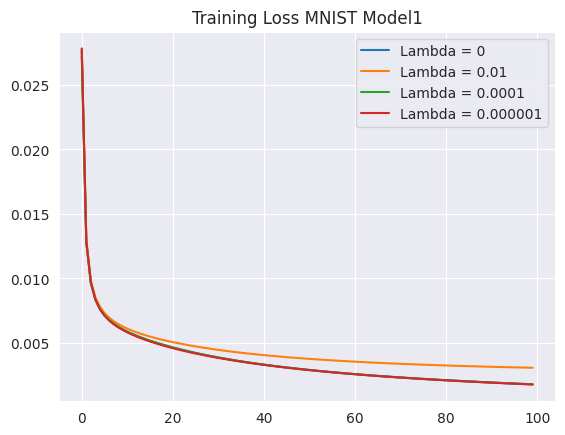

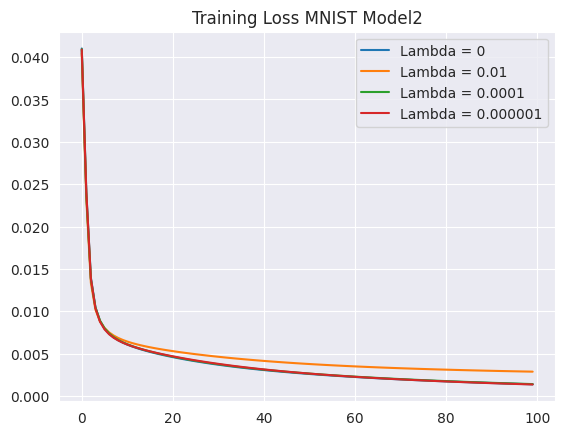

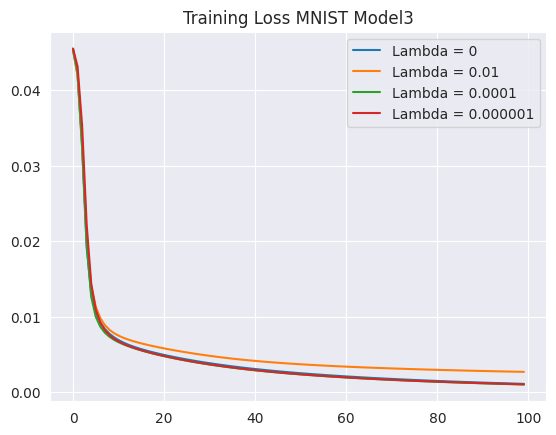

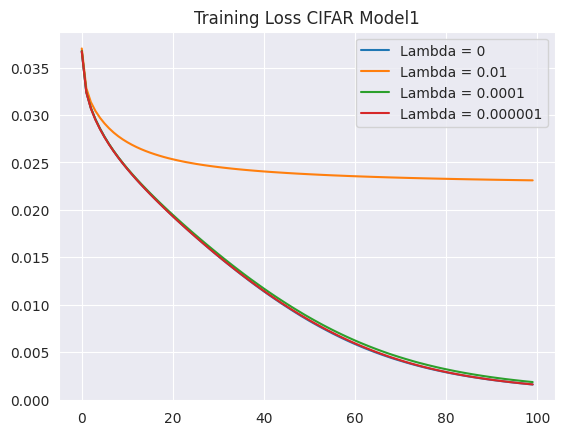

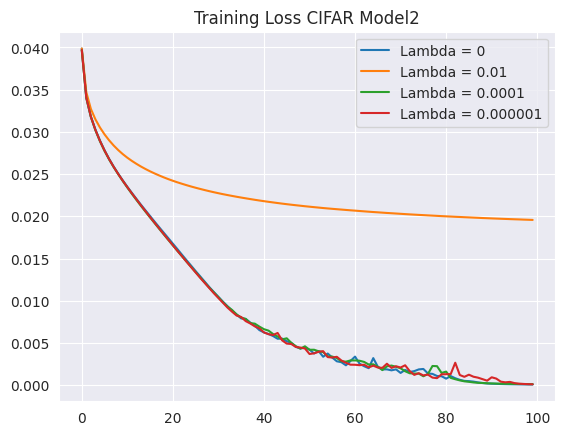

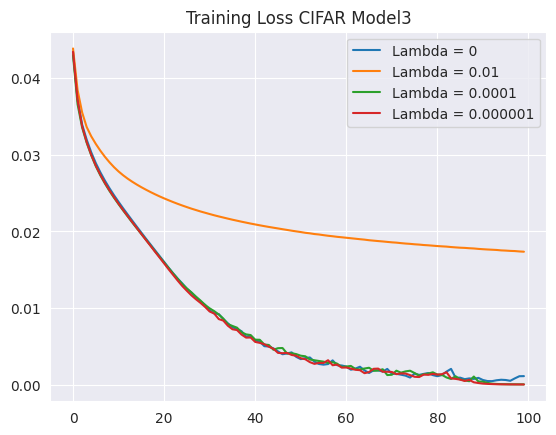

In [30]:
for dataset in ['mnist','cifar']:
    for i,model_name in enumerate(['1hidden', '2hidden', '3hidden']):
        sns.set_style("darkgrid")
        fig = plt.figure()
        for l2 in ['0', '2', '4', '6']:
            name = 'sgd1_' + model_name + '_' + dataset + '_reg' + l2
            plt.plot(range(100), results_sgd1[name][0])
            
        plt.legend(loc = 'upper right', labels = ['Lambda = 0', 'Lambda = 0.01', 'Lambda = 0.0001', 'Lambda = 0.000001'])
        plt.title('Training Loss '+str(dataset).upper() +' Model'+str(i+1))
        plt.show()

## Experiments: SGD with decaying step size

In this case we consider the previously shown stochastci gradient descent with exponentally decaying step size with a decay rate $\gamma = 0.95499 \approx 0.955$. The decay rate is chosen such that the LR decays to $1/100^{th}$ of its initial value after 100 epochs ie. $\gamma^{100} = 0.01$. 

In [19]:
gamma = 0.955

In [20]:
# results_sgd2 = {}

In [21]:
with open('./logs/results_sgd2.txt', 'rb') as f:
    results_sgd2 = pickle.load(f)

# with open('./logs/sgd2.log', 'w') as f:
# sys.stdout = f 
regs = ['6']
counter = 19
for l2 in regs:
    for dataset in ['mnist','cifar']:
        lr = 0.001 if dataset == 'mnist' else 0.01
        for model in ['1hidden', '2hidden', '3hidden']:
            print('Experiment', counter)
            print('Dataset:', dataset)
            print('Model:', model)
            print('LR:', 0.001 if dataset == 'mnist' else 0.01)

            counter += 1
            tick = datetime.now()
            name, loss, acc = train(model_name = model, dataset = dataset, lr = lr, l2 = l2, lr_decay = gamma)
            results_sgd2[name] = (loss, acc)
            tock = datetime.now()
            with open('./logs/results_sgd2.txt', 'wb') as f1:
                pickle.dump(results_sgd2, f1) 

            print()
            print('Time Taken:', tock - tick)
            print()
            print('*********************************************************************')

Experiment 19
Dataset: mnist
Model: 1hidden
LR: 0.001
Lambda: 1e-06
Iter 10 :  Loss: 0.006368097525524597 Acc: 0.9099666666666667
Iter 20 :  Loss: 0.005435250068238626 Acc: 0.9229666666666667
Iter 30 :  Loss: 0.005024772840862473 Acc: 0.92925
Iter 40 :  Loss: 0.004800694956816733 Acc: 0.9323666666666667
Iter 50 :  Loss: 0.004669936619202296 Acc: 0.9341333333333334
Iter 60 :  Loss: 0.004591073576360941 Acc: 0.9354666666666667
Iter 70 :  Loss: 0.004542569395620376 Acc: 0.93605
Iter 80 :  Loss: 0.004512448731344193 Acc: 0.9362833333333334
Iter 90 :  Loss: 0.004493620609709372 Acc: 0.9366166666666667
Iter 100 :  Loss: 0.0044818096673116085 Acc: 0.9368166666666666

Time Taken: 0:20:06.923940

*********************************************************************
Experiment 20
Dataset: mnist
Model: 2hidden
LR: 0.001
Lambda: 1e-06
Iter 10 :  Loss: 0.006772544105164707 Acc: 0.90405
Iter 20 :  Loss: 0.005548657696135342 Acc: 0.92035
Iter 30 :  Loss: 0.005052100214920938 Acc: 0.9277
Iter 40 :  Lo

In [23]:
with open('./logs/results_sgd2.txt', 'rb') as f:
    results_sgd2 = pickle.load(f)
len(results_sgd2.keys())

24

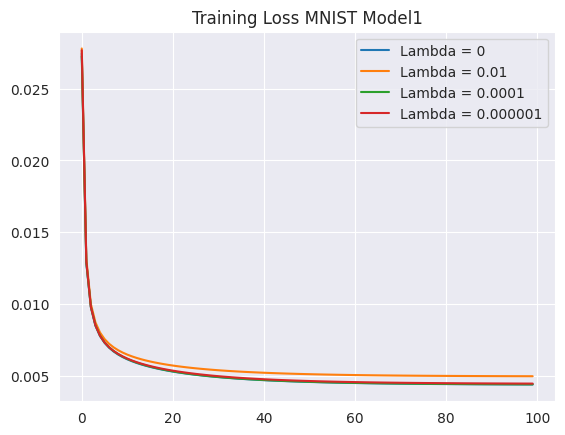

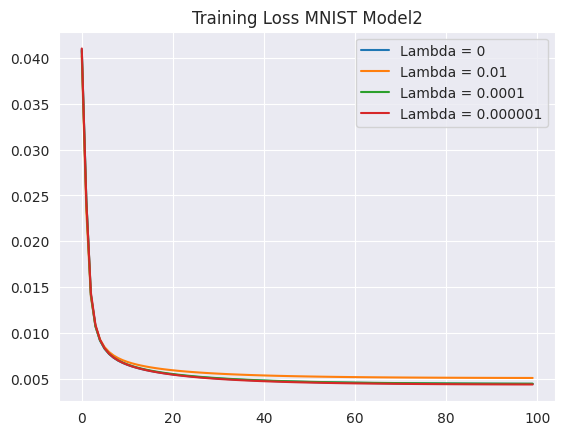

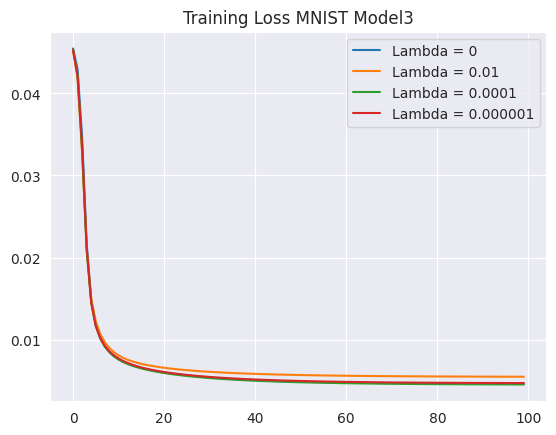

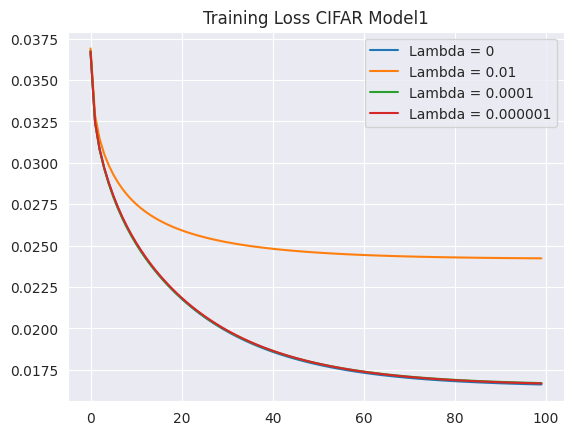

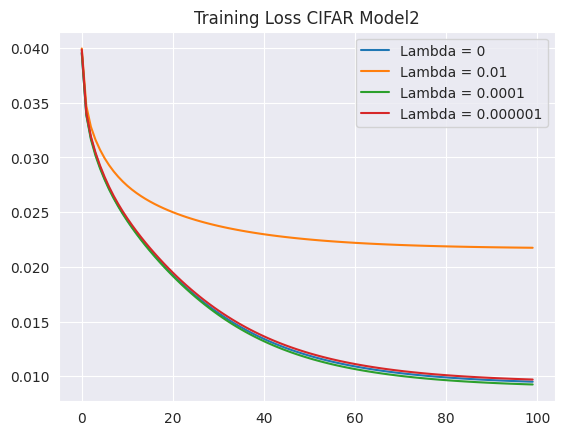

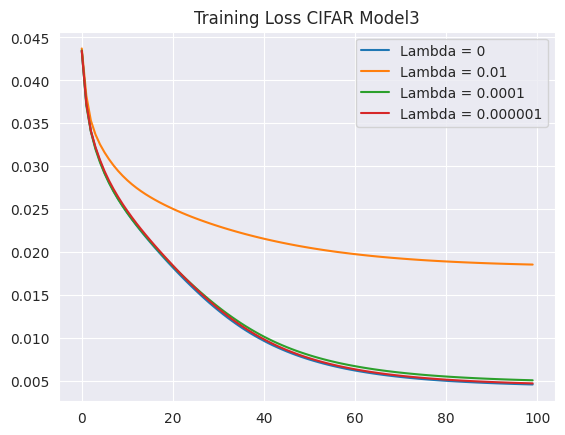

In [24]:
for dataset in ['mnist','cifar']:
    for i,model_name in enumerate(['1hidden', '2hidden', '3hidden']):
        sns.set_style("darkgrid")
        fig = plt.figure()
        for l2 in ['0', '2', '4', '6']:
            name = 'sgd1_' + model_name + '_' + dataset + '_reg' + l2
            plt.plot(range(100), results_sgd2[name][0])
            
        plt.legend(loc = 'upper right', labels = ['Lambda = 0', 'Lambda = 0.01', 'Lambda = 0.0001', 'Lambda = 0.000001'])
        plt.title('Training Loss '+str(dataset).upper() +' Model'+str(i+1))
        plt.show()

## Experiments: Adam Optimizer

In [43]:
# results_adam = {}

In [45]:
with open('./logs/results_adam.txt', 'rb') as f:
    results_adam = pickle.load(f)

# with open('./logs/adam.log', 'w') as f:
# sys.stdout = f 
regs = ['0', '2', '4', '6']
counter = 1
for l2 in regs:
    for dataset in ['cifar']:
        lr = 0.001 if dataset == 'mnist' else 0.001
        for model in ['1hidden', '2hidden', '3hidden']:
            print('Experiment', counter)
            print('Dataset:', dataset)
            print('Model:', model)
            print('LR:', 0.001 if dataset == 'mnist' else 0.01)

            counter += 1
            tick = datetime.now()
            name, loss, acc = train(model_name = model, dataset = dataset, lr = lr, l2 = l2, opt = 'Adam')
            results_adam[name] = (loss, acc)
            tock = datetime.now()
            with open('./logs/results_adam.txt', 'wb') as f1:
                pickle.dump(results_adam, f1) 

            print()
            print('Time Taken:', tock - tick)
            print()
            print('*********************************************************************')

Experiment 1
Dataset: cifar
Model: 1hidden
LR: 0.01
Lambda: 0
Iter 10 :  Loss: 0.018924742010235786 Acc: 0.6897
Iter 20 :  Loss: 0.012694936895370483 Acc: 0.79998
Iter 30 :  Loss: 0.00977968349903822 Acc: 0.8531
Iter 40 :  Loss: 0.008577890440002085 Acc: 0.87962
Iter 50 :  Loss: 0.007251272826343775 Acc: 0.90358
Iter 60 :  Loss: 0.0070139767986908555 Acc: 0.91298
Iter 70 :  Loss: 0.005712273562215269 Acc: 0.92728
Iter 80 :  Loss: 0.00564947488617152 Acc: 0.93348
Iter 90 :  Loss: 0.004907625283487141 Acc: 0.94352
Iter 100 :  Loss: 0.0049202486427407715 Acc: 0.9462

Time Taken: 0:15:44.705010

*********************************************************************
Experiment 2
Dataset: cifar
Model: 2hidden
LR: 0.01
Lambda: 0
Iter 10 :  Loss: 0.01637957724571228 Acc: 0.70912
Iter 20 :  Loss: 0.010017192032337188 Acc: 0.82192
Iter 30 :  Loss: 0.007250540958344936 Acc: 0.87226
Iter 40 :  Loss: 0.005702473495453596 Acc: 0.90182
Iter 50 :  Loss: 0.004727105211094022 Acc: 0.91792
Iter 60 :  Loss

In [47]:
with open('./logs/results_adam.txt', 'rb') as f:
    results_adam = pickle.load(f)
len(results_adam.keys())

24

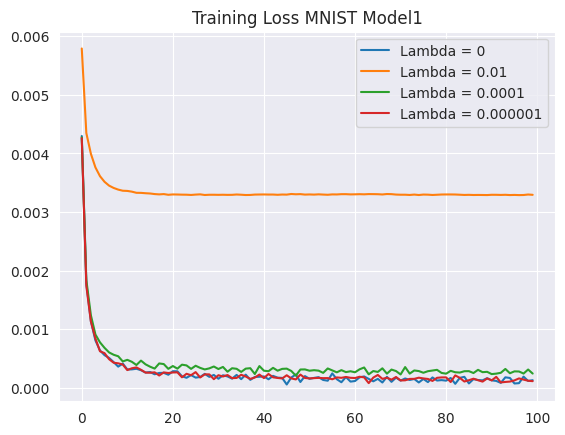

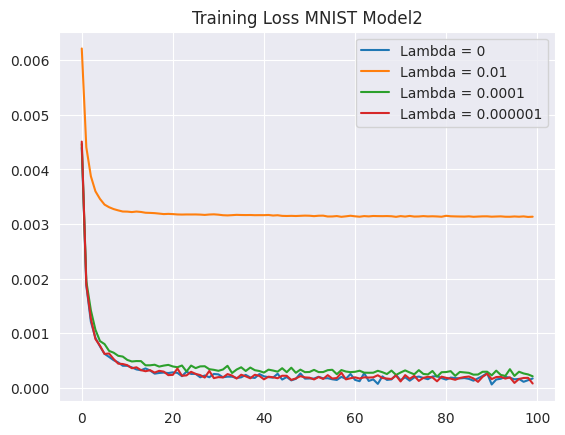

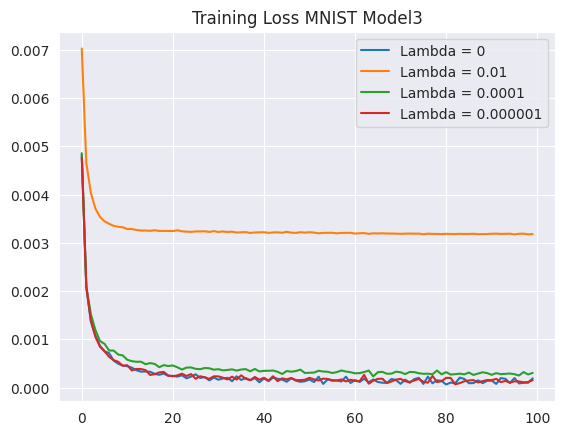

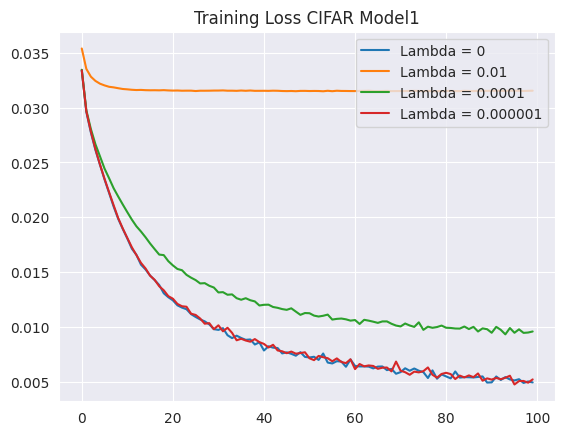

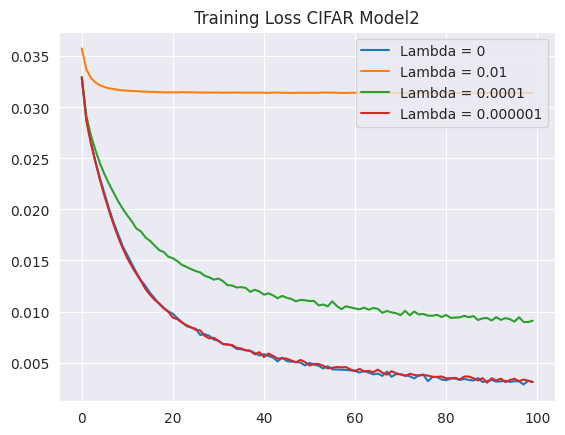

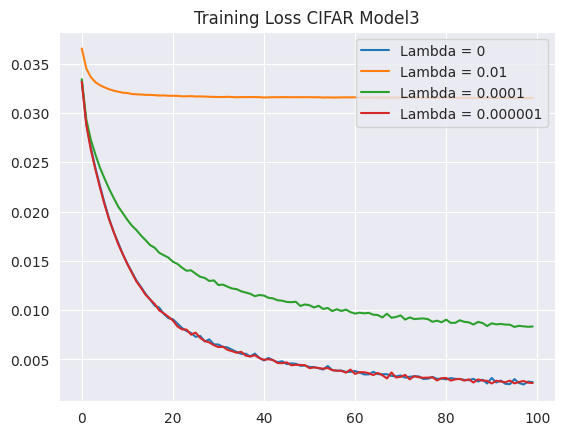

In [48]:
for dataset in ['mnist','cifar']:
    for i,model_name in enumerate(['1hidden', '2hidden', '3hidden']):
        sns.set_style("darkgrid")
        fig = plt.figure()
        for l2 in ['0', '2', '4', '6']:
            name = 'sgd1_' + model_name + '_' + dataset + '_reg' + l2
            plt.plot(range(100), results_adam[name][0])
            
        plt.legend(loc = 'upper right', labels = ['Lambda = 0', 'Lambda = 0.01', 'Lambda = 0.0001', 'Lambda = 0.000001'])
        plt.title('Training Loss '+str(dataset).upper() +' Model'+str(i+1))
        plt.show()

## Results

In [17]:
with open('./logs/results_svrg.txt', 'rb') as f:
    results_svrg = pickle.load(f)
    
with open('./logs/results_sgd1.txt', 'rb') as f:
    results_sgd1 = pickle.load(f)
    
with open('./logs/results_sgd2.txt', 'rb') as f:
    results_sgd2 = pickle.load(f)
    
with open('./logs/results_adam.txt', 'rb') as f:
    results_adam = pickle.load(f)

In [19]:
results = [results_svrg, results_sgd1, results_sgd2, results_adam]

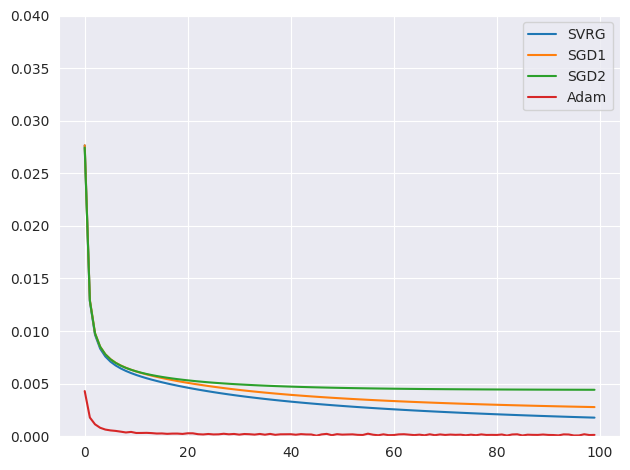

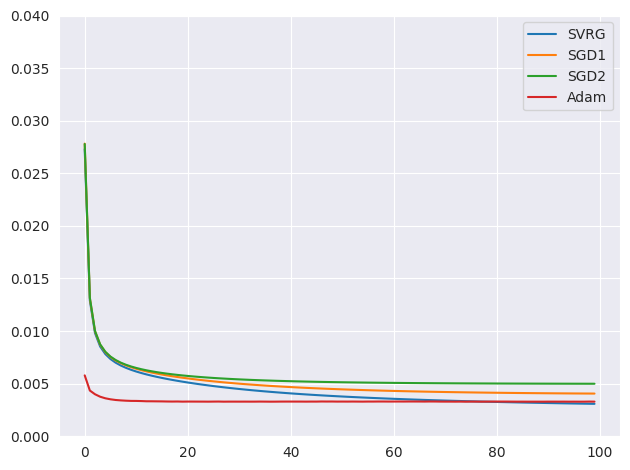

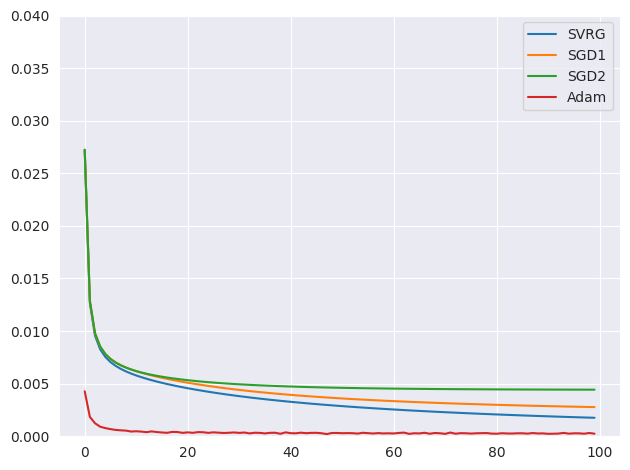

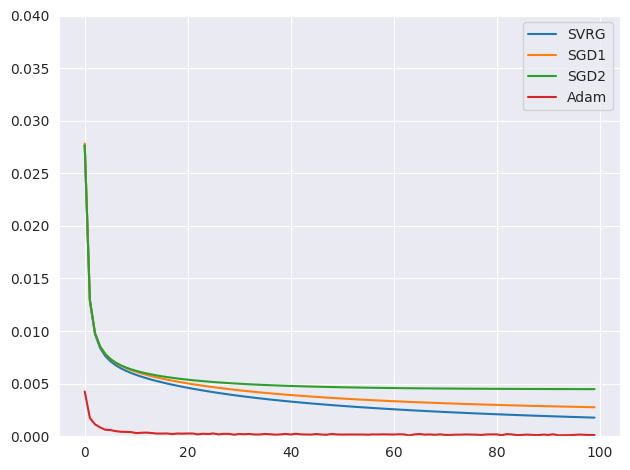

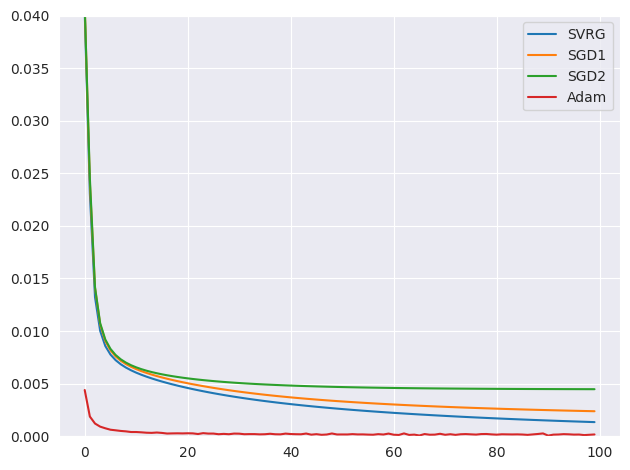

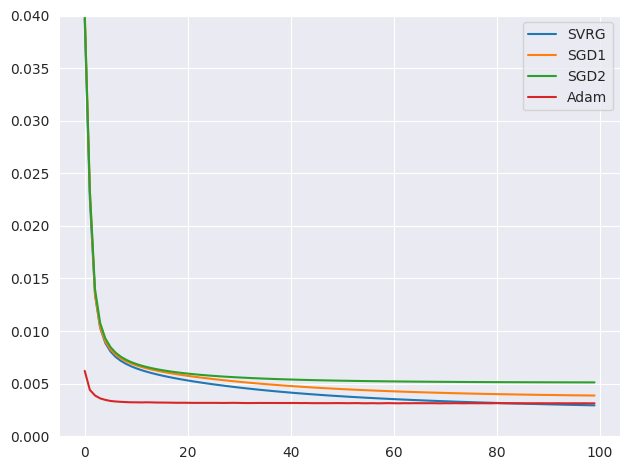

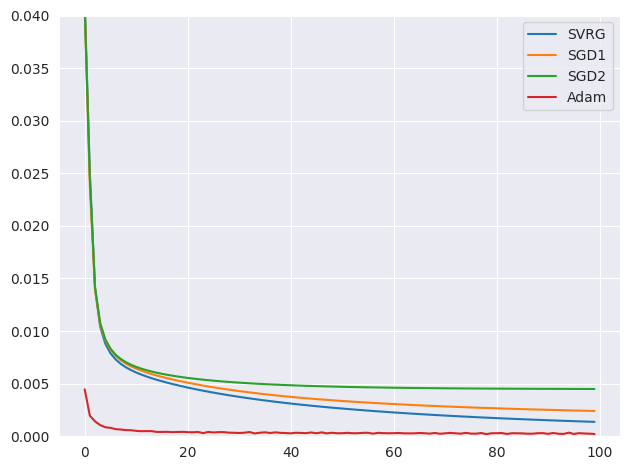

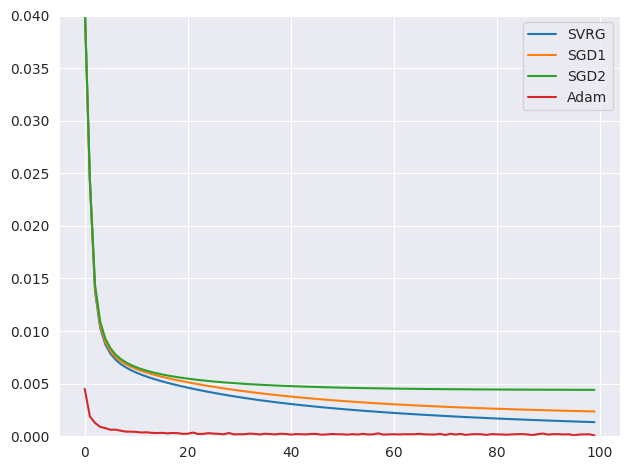

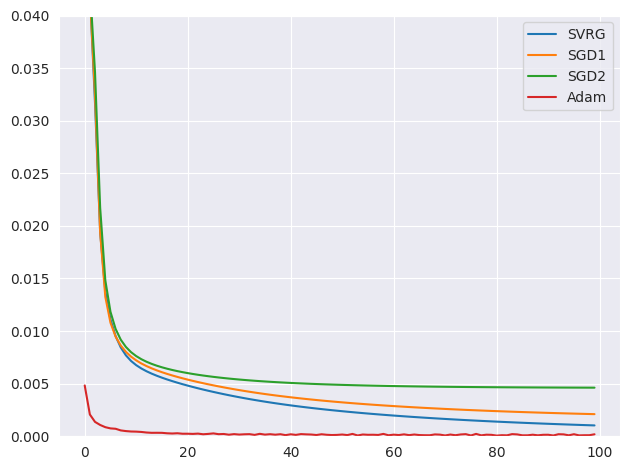

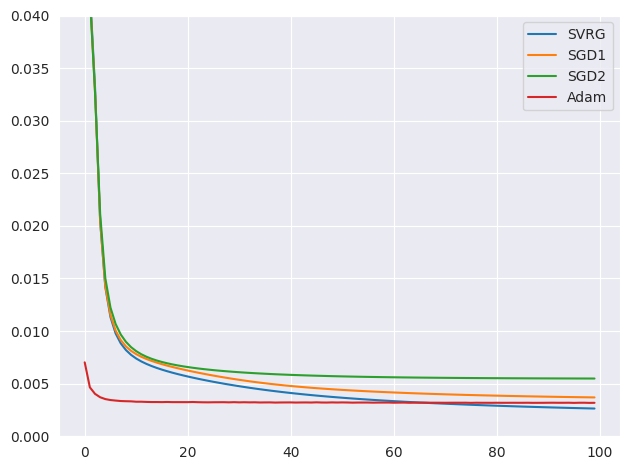

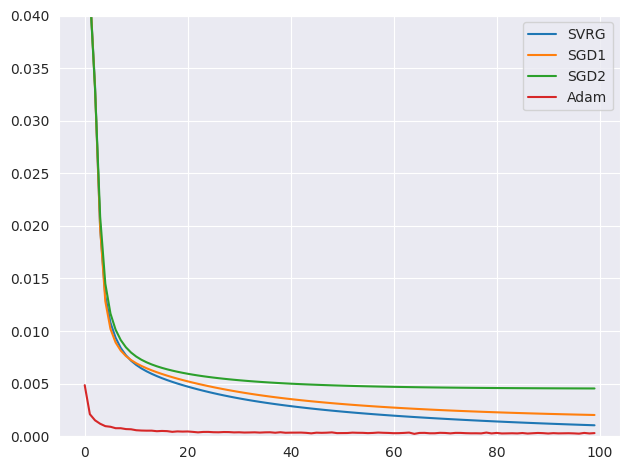

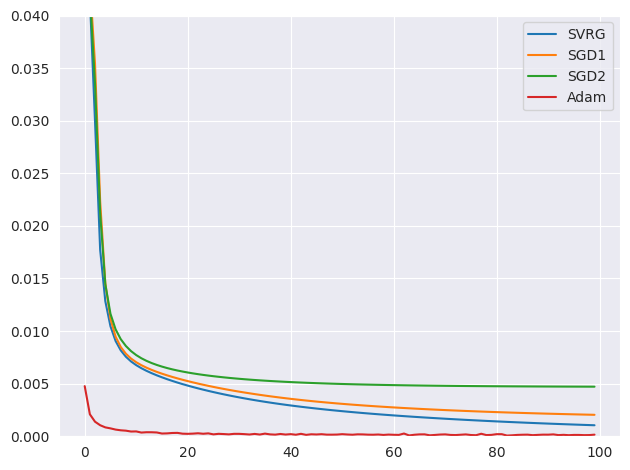

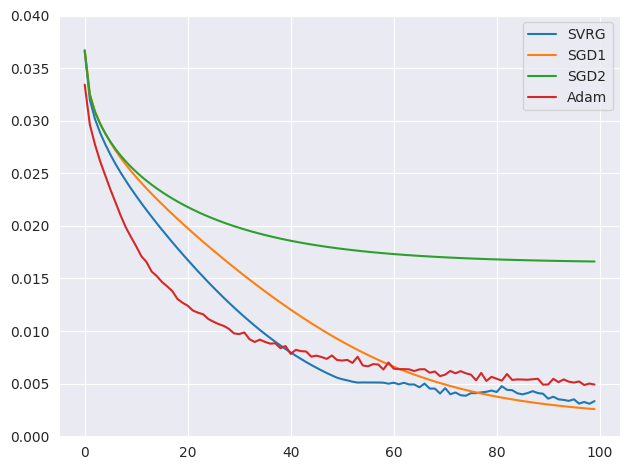

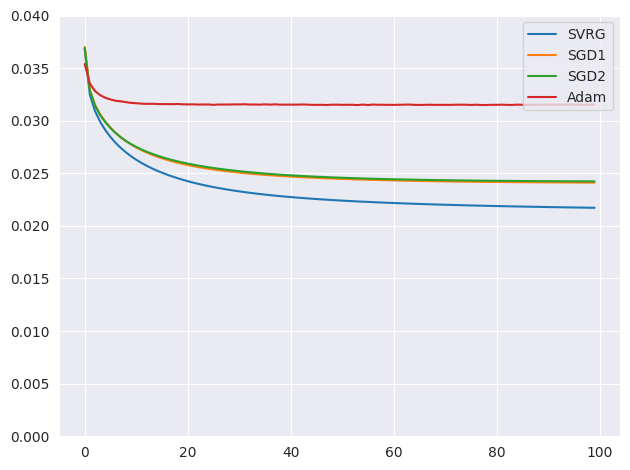

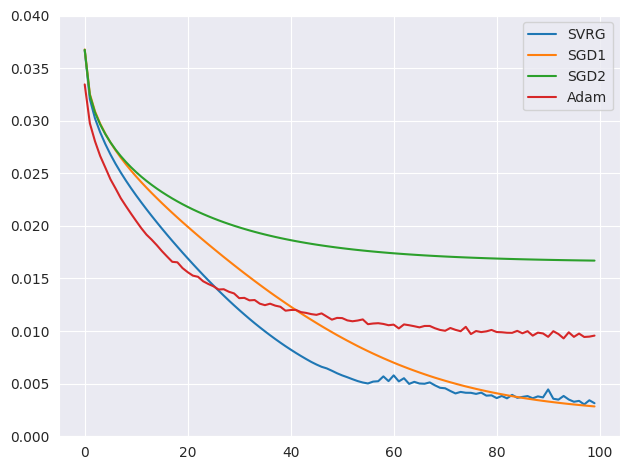

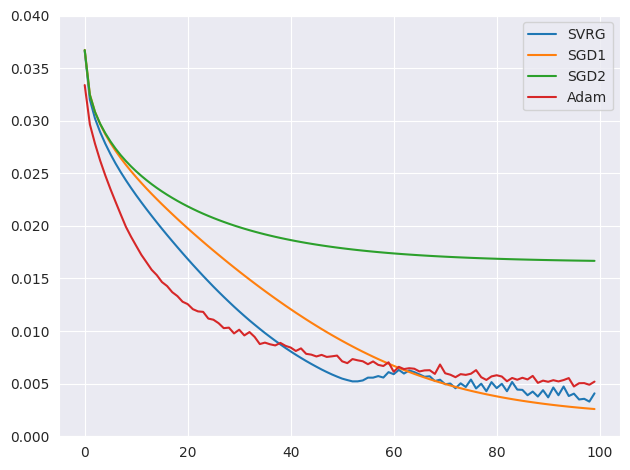

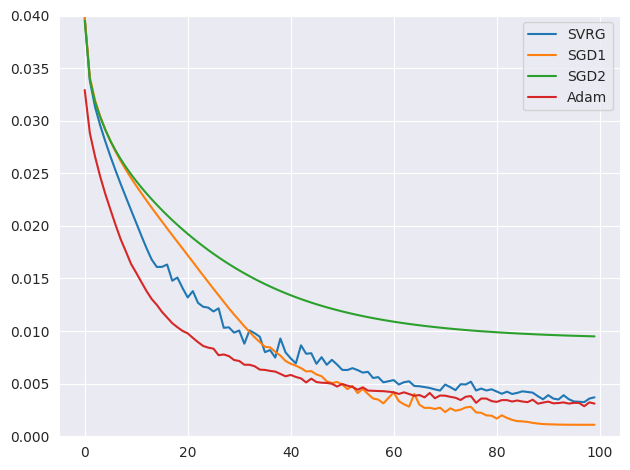

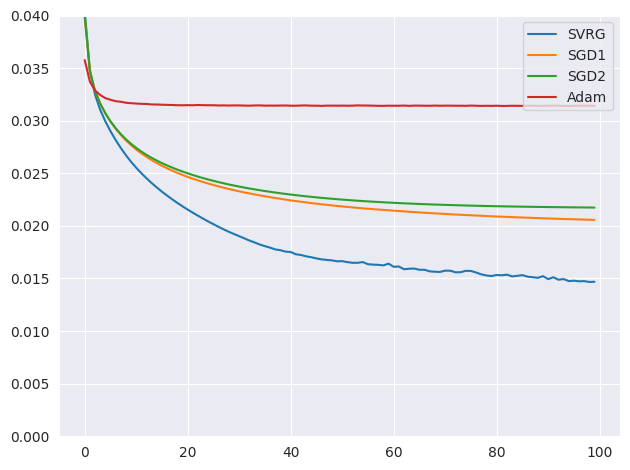

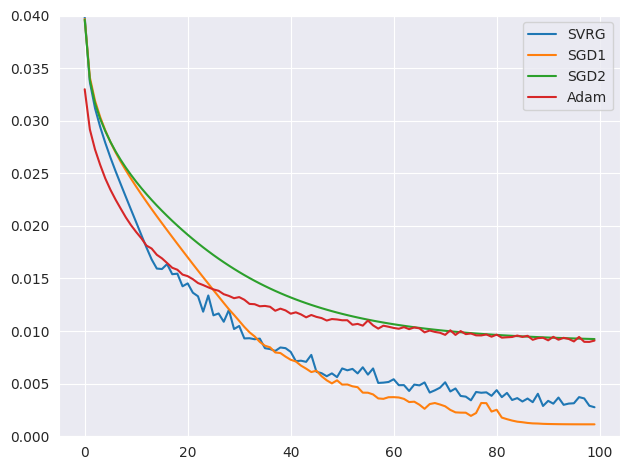

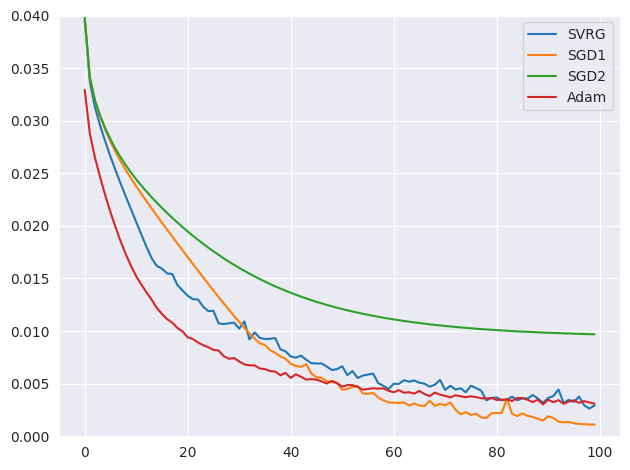

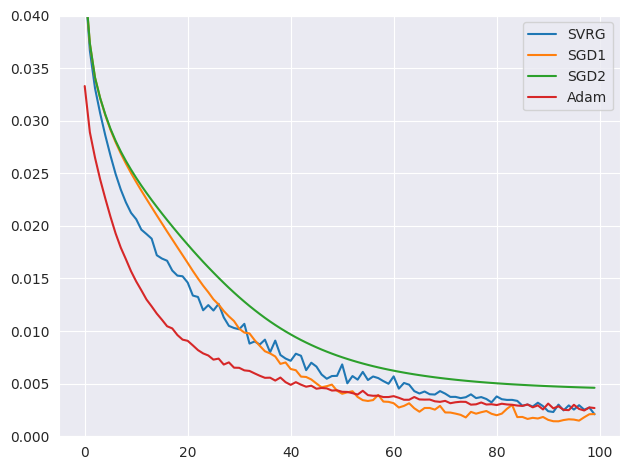

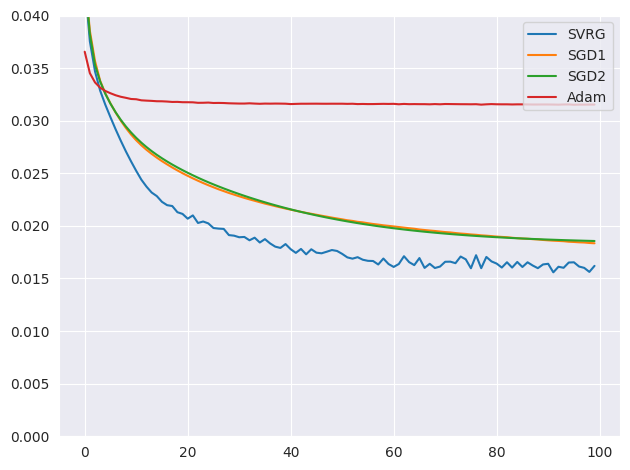

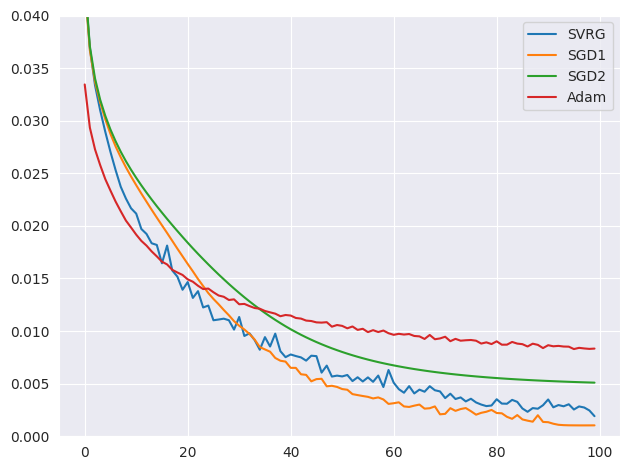

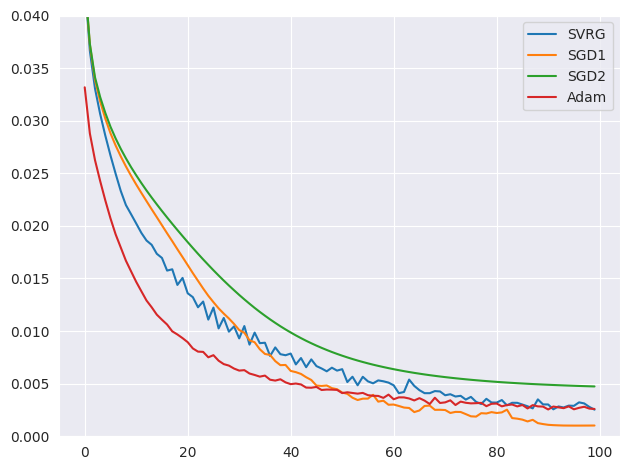

In [20]:
counter = 1
sns.set_style('darkgrid')
for dataset in ['mnist','cifar']:
    for j,model_name in enumerate(['1hidden', '2hidden', '3hidden']):
#         sns.set_style("darkgrid")
        for l2 in ['0', '2', '4', '6']:
            fig = plt.figure()
            for i in [0,1,2,3]:
                name = 'svrg_'
                if i>0: name = 'sgd1_'
                name = name + model_name + '_' + dataset + '_reg' + l2
                plt.plot(range(100), results[i][name][0])
            
            plt.ylim(0.0, 0.04)
            plt.legend(loc = 'upper right', labels = ['SVRG', 'SGD1', 'SGD2', 'Adam'])
#             plt.title('Training Loss '+str(dataset).upper() +' Model'+str(j+1)+' Reg'+l2)
            plt.tight_layout()
            plt.savefig('./plots/img'+str(counter))
            plt.show()
            
            counter += 1